Text(0, 0.5, 'y')

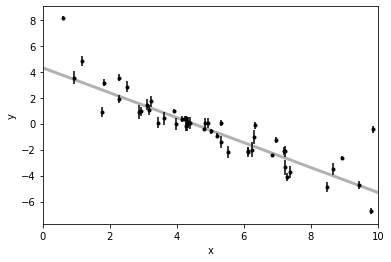

In [31]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50                                  # number of data
x = np.sort(10 * np.random.rand(N))     # ascending random number of x, randn generates from uniform distribution in the range [0,1)
yerr = 0.1 + 0.5 * np.random.rand(N)    # y error at least 0.1
y = m_true * x + b_true                 # the Function is y = mx + b
y += np.abs(f_true * y) * np.random.randn(N) # add deviation that relates to y itself
y += yerr * np.random.randn(N)          # add normal distributed error

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


Text(0, 0.5, 'y')

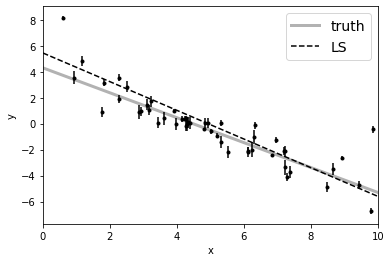

In [3]:
# try to solve with least squares estimates 
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2)) 

print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [32]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2)) # likelihood function

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


array([-1.00300852,  4.5283143 , -0.79044033])

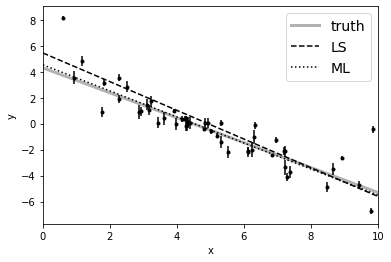

In [37]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)          # define likelihood func. as lambda function
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3) # initial guess
soln = minimize(nll, initial, args=(x, y, yerr))    # input lambda func. with initial guess and find optimize solution
m_ml, b_ml, log_f_ml = soln.x                       # maximum likelihood solution for x axis

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
soln.x

In [38]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0: # set a reasonable range of parameters
        return 0.0
    return -np.inf

In [7]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp): # if the parameter is not reasonable, return -inf (0 possibility)
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) # set the probability as maximum likelihood 

In [10]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)        # 32 different starting points 
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
) 
sampler.run_mcmc(pos, 5000, progress=True)      # with 5000 iteration

/cluster/home/poya/anaconda3/lib/python3.9/site-packages/scipy/stats/_ksstats.py:74: RuntimeWarning: invalid value encountered in ldexp
  _EP128 = np.ldexp(np.longdouble(1), _E128)
100%|██████████| 5000/5000 [00:08<00:00, 575.18it/s]


State([[-0.98884372  4.44165434 -0.40161855]
 [-1.10384469  4.96002303 -0.99975964]
 [-1.09034399  4.96077912 -0.93670509]
 [-0.97513489  4.354894   -0.8896129 ]
 [-1.06975217  4.75196717 -0.97362866]
 [-1.04399814  4.66855063 -0.66782533]
 [-1.10623177  4.95869911 -0.70208343]
 [-1.23035772  5.4796779  -0.89405843]
 [-1.016971    4.65534943 -0.92615788]
 [-1.02751994  4.55828135 -0.56867363]
 [-0.97126131  4.43746758 -0.94651495]
 [-0.96780754  4.302868   -0.78862666]
 [-0.94380876  4.19665694 -0.65157412]
 [-1.04568303  4.63162009 -0.73792623]
 [-1.10833579  4.95911657 -0.85898236]
 [-0.93707902  4.22115931 -0.82394525]
 [-0.98541475  4.4104789  -0.77316124]
 [-0.91796732  4.09701617 -0.74178466]
 [-1.15109647  5.18805688 -1.0242736 ]
 [-1.00073666  4.48060221 -0.81793467]
 [-1.00068796  4.54010832 -0.73151334]
 [-0.94507458  4.27696731 -0.53857772]
 [-0.91390861  4.12703737 -0.56183687]
 [-1.18202666  5.34033412 -0.95391651]
 [-1.08001219  4.88906252 -0.80309308]
 [-1.07146691  4.80

Text(0.5, 0, 'step number')

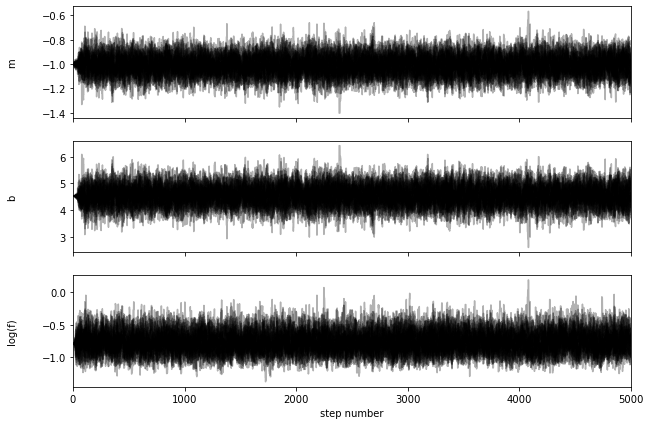

In [11]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()       # get 32 values for each time (within 5000)
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [12]:
tau = sampler.get_autocorr_time()
print(tau)      
# This suggests that only about 40 steps are needed for the chain to “forget” where it started.

[39.16329084 39.96660169 35.8864348 ]


In [13]:
# Let’s discard the initial 100 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


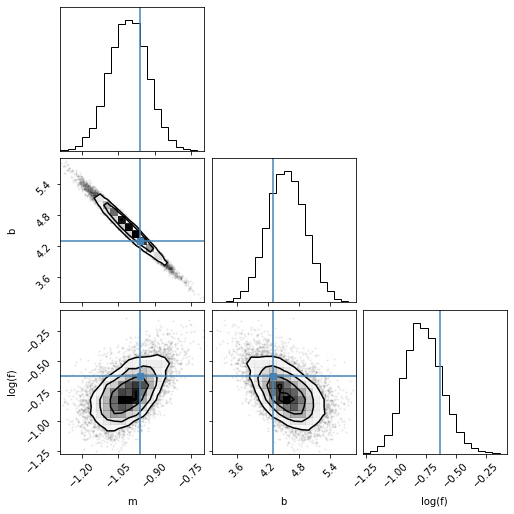

In [15]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
)

Text(0, 0.5, 'y')

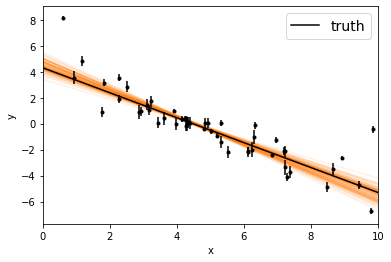

In [16]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)     # dot product of np.vander and sample --> y=mx+b
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [17]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>